In [1]:
import pandas as pd
import nltk
from scipy.stats import zscore
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import string

In [2]:
# Load Reviews

df1 = pd.read_csv('Hostel Reviews NYC Batch.csv')
df2 = pd.read_csv('Hostel Reviews Seattle Batch.csv')

dfr = pd.concat([df1,df2])
dfr.reset_index(drop=True,inplace=True);

In [3]:
# Define a series of functions for common pre-processing that can also be used for other projects

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sacremoses import MosesDetokenizer
import gensim
import re

def lowerCase(sentence):
    clean = sentence.lower()
    return clean

def removePunc(sentence):
    clean = re.sub(r'[?|!|\'|"|#.,:$]',r'',sentence)
    clean = clean.strip()
    return clean

def removeNum(sentence):
    clean = re.sub(r'\d+','',sentence)
    return clean

def removeStopWords(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    temp = [i for i in tokens if not i in stop_words]
    detokenizer = MosesDetokenizer()
    return detokenizer.detokenize(temp, return_str=True)

def stemSentence(sentence):
    stemmer = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def lemSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(sentence)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word))
        lem_sentence.append(" ")
    return "".join(lem_sentence)


def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text)

# Tokenize and lemmatize
def preprocess(text):
    result = []
    text = word_tokenize(text)
    for token in text :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token,simplify(pos)) for token, pos in nltk.pos_tag(token))
              result.append(stemSentence(lemmatize_stemming(removePunc(token))).strip())
            
    return result

In [5]:
# Include names of cities in the list of words to ignore

def Words2Ignore(sentence):
    w2ig = ['euro','christopher','new york','boston','london','tokyo','montreal','vancouver','san francisco','los angeles',
            'seattle','chicago','philadelphia','houston','san diego','calgary','berlin','amsterdam',
            'stockholm','birmingham','glasgow','edinburgh','liverpool']
    tokens = word_tokenize(sentence.lower())
    temp = [i for i in tokens if not i in w2ig]
    detokenizer = MosesDetokenizer()
    return detokenizer.detokenize(temp, return_str=True)

In [6]:
# Split train and test sets and use the train set for LDA

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(dfr, test_size=0.30, shuffle=True)
text_train = X_train['Review']
text_test = X_test['Review']

In [7]:
processed_docs = [];

for revs in text_train:
    revs = Words2Ignore(revs) 
    revs = removeNum(revs).strip()
    processed_docs.append(preprocess(revs))

In [8]:
# Dictionary should be created after pre-processing to reduce unwanted words

dictionary = gensim.corpora.Dictionary(processed_docs)

In [9]:
# Check that the dictionary has been made

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
dictionary.filter_extremes(no_below=30, no_above=0.1)

0 breakfast
1 close
2 good
3 minut
4 option
5 person
6 price
7 station
8 valu
9 victoria
10 walk


In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

In [11]:
# Clean the corpus

bow_corpus_clean = []

for numIt in bow_corpus:
    if len(numIt) > 0:
        bow_corpus_clean.append(numIt)

In [12]:
# Set up function for MALLET LDA for use with different topic numbers. Output coherence scores.
# Several functions for display have been inspired by MachineLearningPlus.com
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel

mallet_path = 'mallet-2.0.8/bin/mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary, bow_corpus_clean, processed_docs, 15, 1, 1)

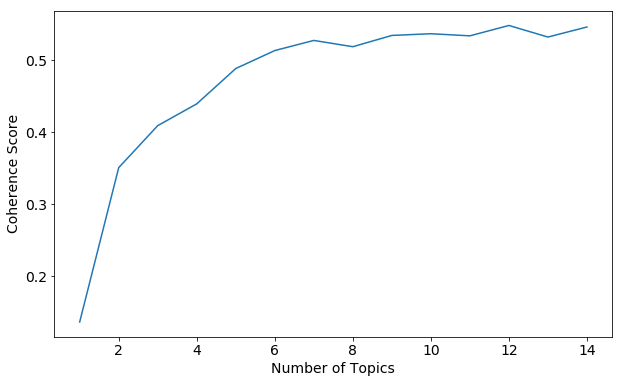

<Figure size 864x432 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

# Show graph

limit=15; start=1; step=1;
x = range(start, limit, step)
fig = plt.figure(figsize=(10,6))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics",fontsize=14)
plt.ylabel("Coherence Score",fontsize=14)
plt.tick_params(axis="both",which="major",labelsize=14)
plt.figure(figsize=(12,6))
plt.show()

In [15]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.1368
Num Topics = 2  has Coherence Value of 0.3509
Num Topics = 3  has Coherence Value of 0.4092
Num Topics = 4  has Coherence Value of 0.4394
Num Topics = 5  has Coherence Value of 0.4884
Num Topics = 6  has Coherence Value of 0.5133
Num Topics = 7  has Coherence Value of 0.5274
Num Topics = 8  has Coherence Value of 0.5186
Num Topics = 9  has Coherence Value of 0.5343
Num Topics = 10  has Coherence Value of 0.5367
Num Topics = 11  has Coherence Value of 0.5337
Num Topics = 12  has Coherence Value of 0.5481
Num Topics = 13  has Coherence Value of 0.532
Num Topics = 14  has Coherence Value of 0.546


In [20]:
# Select optimal model and print the topics

optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.037*"sleep" + 0.034*"floor" + 0.032*"toilet" + 0.027*"door" + 0.021*"open" + 0.019*"build" + 0.017*"loud" + 0.017*"water" + 0.017*"outsid" + 0.016*"window"'), (1, '0.031*"check" + 0.027*"book" + 0.021*"recept" + 0.018*"arriv" + 0.017*"hour" + 0.015*"charg" + 0.014*"morn" + 0.013*"desk" + 0.013*"guest" + 0.013*"leav"'), (2, '0.056*"kitchen" + 0.051*"dorm" + 0.047*"locker" + 0.045*"small" + 0.029*"secur" + 0.027*"wifi" + 0.026*"space" + 0.020*"common" + 0.020*"lock" + 0.019*"bunk"'), (3, '0.069*"love" + 0.056*"definit" + 0.046*"amaz" + 0.039*"perfect" + 0.032*"enjoy" + 0.031*"comfort" + 0.031*"experi" + 0.027*"excel" + 0.019*"highli" + 0.019*"welcom"'), (4, '0.054*"super" + 0.053*"travel" + 0.045*"free" + 0.039*"meet" + 0.031*"awesom" + 0.027*"cool" + 0.025*"food" + 0.021*"social" + 0.020*"vibe" + 0.020*"lot"'), (5, '0.044*"price" + 0.043*"overal" + 0.041*"pretti" + 0.038*"littl" + 0.030*"feel" + 0.029*"money" + 0.027*"hotel" + 0.027*"valu" + 0.027*"thing" + 0.027*"felt"'), (6, '

In [21]:
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(optimal_model, bow_corpus_clean, processed_docs)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1779,"station, citi, easi, minut, train, central, co...","[good, breakfast, option, person, price, valu,..."
1,1,5.0,0.1779,"price, overal, pretti, littl, feel, money, hot...","[center, import, point, price, think, close, e..."
2,2,6.0,0.1749,"station, citi, easi, minut, train, central, co...","[best, hostel, stay, entir, trip, metro, stati..."
3,3,1.0,0.2637,"check, book, recept, arriv, hour, charg, morn,...","[extra, sheet, extra, money, better, hostel, w..."
4,4,4.0,0.1770,"super, travel, free, meet, awesom, cool, food,...","[piggi, rock, great, experi, stay, everybodi, ..."
5,5,2.0,0.2422,"kitchen, dorm, locker, small, secur, wifi, spa...","[price, recept, guest, nice, upbeat, facil, lo..."
6,6,2.0,0.1782,"kitchen, dorm, locker, small, secur, wifi, spa...","[hostel, beaten, path, quiet, neighborhood, wa..."
7,7,2.0,0.1811,"kitchen, dorm, locker, small, secur, wifi, spa...","[actual, stay, past, impress, second, time, ne..."
8,8,1.0,0.1812,"check, book, recept, arriv, hour, charg, morn,...","[impress, staff, hostel, central, locat, worth..."
9,9,6.0,0.2164,"station, citi, easi, minut, train, central, co...","[night, japan, get, airport, easi, haneda, gre..."


In [22]:
# Display the keywords for each topic 

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format Columns
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Display Topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3791,"sleep, floor, toilet, door, open, build, loud,...","[great, locat, fantast, staff, good, facil, is..."
1,1.0,0.4377,"check, book, recept, arriv, hour, charg, morn,...","[hostel, perfect, amen, good, loung, area, goo..."
2,2.0,0.3511,"kitchen, dorm, locker, small, secur, wifi, spa...","[great, place, stay, bed, clean, comfort, bath..."
3,3.0,0.3243,"love, definit, amaz, perfect, enjoy, comfort, ...","[good, place, girlfriend, privat, room, nice, ..."
4,4.0,0.3682,"super, travel, free, meet, awesom, cool, food,...","[great, stay, budget, conveni, locat, nice, st..."
5,5.0,0.2947,"price, overal, pretti, littl, feel, money, hot...","[properti, easi, sweet, curtain, bed, nice, pr..."
6,6.0,0.4045,"station, citi, easi, minut, train, central, co...","[great, environ, easi, meet, peopl, room, host..."


In [44]:
# Save the model and dictionary as pickles

import pickle 

pkl_filename = "pickle_model_mallet.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(optimal_model, file)
    
pkl_filename2 = "pickle_dict_mallet.pkl"  
with open(pkl_filename2, 'wb') as file:  
    pickle.dump(dictionary, file)

In [23]:
# pyLDAvis does not work with MALLET LDA, so MALLET has to be converted to gensim LDA prior to visualization

tmpmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(tmpmodel, bow_corpus_clean, dictionary)
pyLDAvis.display(lda_display)

/Users/benjaminchew/anaconda3/envs/Insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/benjaminchew/anaconda3/envs/Insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/benjaminchew/anaconda3/envs/Insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/benjaminchew/anaconda3/envs/Insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default